In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:95%  }</style>")

In [2]:
%matplotlib inline
from IPython.display import IFrame

### usual imports

In [3]:
import os
import sys
from glob import glob 

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### fbprophet 

[fbprophet](https://facebook.github.io/prophet/) implement a [Generalized Additive Model](https://en.wikipedia.org/wiki/Generalized_additive_model) in Python and R, and is extremely convenient for the modelling of time-series which contain a **trend** (potentially non-linear), some **cyclic components** (e.g. seasonal cycle, weekly cycle, daily cycle, ...) and potentially responds
to **`pulse` events** which do not obey a regular schedule, the latter is particularly important for e.g. time-series of sales data, where holidays, special events, marketing campains, etc, might drive short term, irregular increases or decrease in sales volume / value.   

And of course, of interest for us is the fact that you can easily add **extra regressors** to the model: in our case it is likely to be climate / weather variables, and the formulation of the model makes is relatively easy to quantify the added value derived from incorporating climate / weather explanatory variables to the model.

to know more about the **Generalized Additive Model** framework, a good start is:   
    
[https://multithreaded.stitchfix.com/assets/files/gam.pdf](https://multithreaded.stitchfix.com/assets/files/gam.pdf)

and below is the **fbprophet** website, I strongly recommend reading the paper, which is very well written and clear

In [5]:
IFrame(src='https://facebook.github.io/prophet/', width=1500, height=600)

### import fbprophet 

In [6]:
from fbprophet import Prophet

### scikit learn Mean Absolute Error metrics function (MAE)

In [7]:
from sklearn.metrics import mean_absolute_error as MAE

### seaborn for visualisation 

In [8]:
import seaborn as sns

### read the data: cycling counts over Tamaki drive 

the data is taken from [https://awcc.mrcagney.works/](https://awcc.mrcagney.works/)

In [9]:
IFrame(src='https://awcc.mrcagney.works/', width='100%', height=600)

### for a slightly more convenient view of the location of the counters, we're gonna create an interactive map in the Jupyter Notebook using [https://github.com/python-visualization/folium](https://github.com/python-visualization/folium)

#### reads in the locations of the counters 

In [10]:
loc_counters = pd.read_csv('../data/cycling_Auckland/cycling_counters.csv')

In [11]:
loc_counters.head()

,name,id,Name.1,latitude,longitude,site_code,setup_date,user_type
0,Beach Road,100017404,Beach Road,-36.849384,174.774410,Y2H16100775,01/10/2014,Cyclists
1,Carlton Gore Cycle Counter,100015328,Carlton Gore Cycle Counter,-36.864330,174.772540,Y2G14076121,05/08/2015,Cyclists
2,Curran Street Road,100026985,Curran Street Road,-36.837985,174.739518,U15G5118789,17/11/2015,Cyclists
3,Curran Street Shared Path,100026328,Curran Street Shared Path,-36.838901,174.739392,Y2H17082968,17/11/2015,Pedestrians/Cyclists
4,Dominion Rd City Bound,100038514,Dominion Rd City Bound,-36.870317,174.752791,Y2H17062384,25/07/2017,Cyclists


#### we're only keeping the counters for cyclists

In [12]:
loc_counters = loc_counters.query("user_type == 'Cyclists'")

### we're gonna centre the map on the Tamaki Drive counter 

In [13]:
loc_counters.query("name == 'Tamaki Drive EB'")

,name,id,Name.1,latitude,longitude,site_code,setup_date,user_type
44,Tamaki Drive EB,100000827,Tamaki Drive EB,-36.847782,174.78935,ECO08011685,12/11/2009,Cyclists


In [14]:
center_lat = loc_counters.query("name == 'Tamaki Drive EB'").latitude.values[0]
center_lon = loc_counters.query("name == 'Tamaki Drive EB'").longitude.values[0]

### display the counters locations on an interactive map

In [15]:
import folium
from folium.plugins import MarkerCluster

In [16]:
folium.__version__

'0.5.0+146.g41e494d'

this is the development version of folium

In [17]:
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles='OpenStreetMap', 
    width='80%', 
)

m.add_child(folium.LatLngPopup())

# marker_cluster = MarkerCluster().add_to(m)

# loops over each row in the DataFrame holding the counters information, and 
# adds to the map 

for i, row in loc_counters.iterrows():
    name = row['name']
    lat = row.latitude
    lon = row.longitude
    opened = row.setup_date
    
    # HTML here in the pop up 
    popup = '<b>{}</b></br><i>setup date = {}</i>'.format(name, opened)
    
#     folium.Marker([lat, lon], popup='<i>{}</i>'.format(name), tooltip=name).add_to(marker_cluster)
    folium.Marker([lat, lon], popup=popup, tooltip=name).add_to(m)

### now display the map, centered on the Tamaki drive counters 

In [18]:
m

### now reads the cycling counts

#### get the list of files (one per year)

In [19]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

#### sort

In [20]:
lfiles.sort()

In [21]:
lfiles

['../data/cycling_Auckland/cycling_counts_2010.csv',
 '../data/cycling_Auckland/cycling_counts_2011.csv',
 '../data/cycling_Auckland/cycling_counts_2012.csv',
 '../data/cycling_Auckland/cycling_counts_2013.csv',
 '../data/cycling_Auckland/cycling_counts_2014.csv',
 '../data/cycling_Auckland/cycling_counts_2015.csv',
 '../data/cycling_Auckland/cycling_counts_2016.csv',
 '../data/cycling_Auckland/cycling_counts_2017.csv',
 '../data/cycling_Auckland/cycling_counts_2018.csv']

#### loops over the list of files, reads and keep the Tamaki Drive data, and concatenate 

In [22]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True, usecols=['datetime', 'Tamaki Drive EB','Tamaki Drive WB'])
    l.append(d)

In [23]:
df = pd.concat(l, axis=0)

In [24]:
df.head()

,Tamaki Drive EB,Tamaki Drive WB
datetime,,
2010-07-01 00:00:00,2.0,NaN
2010-07-01 01:00:00,3.0,NaN
2010-07-01 02:00:00,1.0,NaN
2010-07-01 03:00:00,1.0,NaN
2010-07-01 04:00:00,2.0,NaN


In [25]:
df.tail()

,Tamaki Drive EB,Tamaki Drive WB
datetime,,
2018-05-31 19:00:00,28.0,11.0
2018-05-31 20:00:00,9.0,2.0
2018-05-31 21:00:00,8.0,6.0
2018-05-31 22:00:00,7.0,4.0
2018-05-31 23:00:00,2.0,0.0


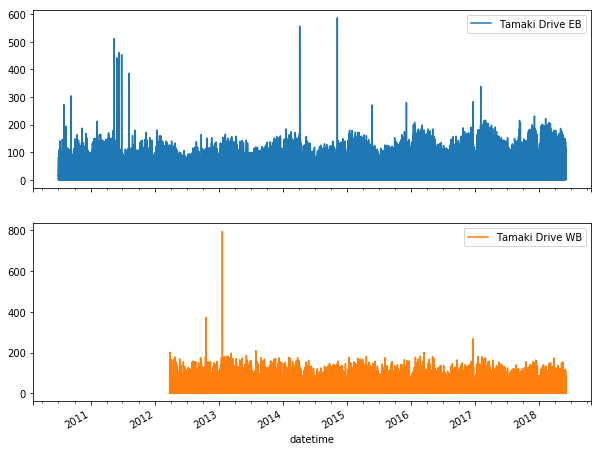

In [26]:
df.plot(subplots=True, figsize=(10, 8));

### we'll keep only the data from 2012 onwards as there seems to be some strange stuff going on in 2011, maybe because the counter was recently installed 

In [27]:
df = df.loc['2012':,:]

### seasonal cycle (30 days running window for smoothing) 

clearly seasonal cycle, people tend to take their bike more during the summer than the winter (to be expected !)

Text(0.5,0,'day of year')

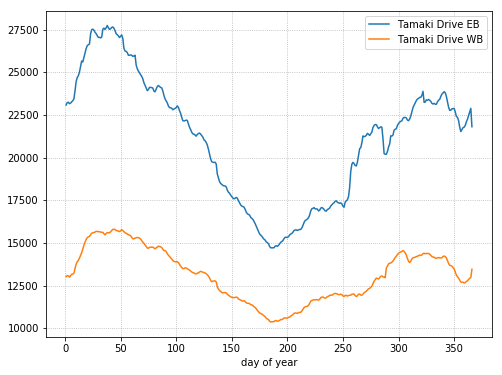

In [28]:
f, ax = plt.subplots(figsize=(8,6)) 
df.rolling(window=30*24, center=True).sum().groupby(df.index.dayofyear).mean().plot(ax=ax)
ax.grid(ls=':')
ax.set_xlabel('day of year')

### weekly cycle 

I expected a clearer pattern for that one ... 

Text(0.5,0,'day of week')

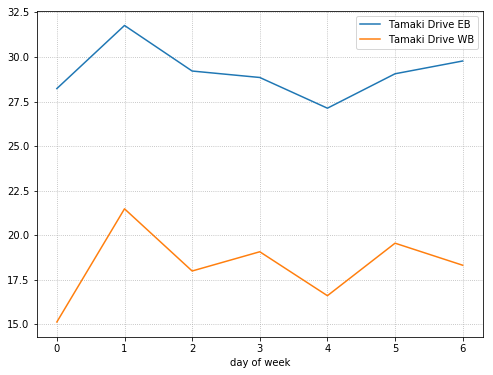

In [29]:
f, ax = plt.subplots(figsize=(8,6)) 
df.groupby(df.index.dayofweek).mean().plot(ax=ax)
ax.grid(ls=':')
ax.set_xlabel('day of week (0 is monday)')

### daily cycle 

In [30]:
summary_hour = df.groupby(df.index.hour).describe()

In [31]:
summary_hour.head()

Tamaki Drive EB                                                 \
                   count      mean       std  min  25%  50%  75%    max   
datetime                                                                  
0                 2339.0  2.020094  3.432600  0.0  0.0  1.0  3.0   66.0   
1                 2341.0  1.097394  4.363886  0.0  0.0  0.0  1.0  136.0   
2                 2341.0  0.667236  2.365147  0.0  0.0  0.0  1.0   63.0   
3                 2343.0  0.537772  2.525059  0.0  0.0  0.0  1.0   74.0   
4                 2343.0  1.152369  4.337029  0.0  0.0  1.0  1.0  184.0   

         Tamaki Drive WB                                                
                   count      mean       std  min  25%  50%  75%   max  
datetime                                                                
0                 2258.0  0.877768  1.219808  0.0  0.0  1.0  1.0  22.0  
1                 2258.0  0.411426  0.751541  0.0  0.0  0.0  1.0   9.0  
2                 2257.0  0.279575  0.582163  0.0  0.0  0.0  0.0   5.0  
3                 2258.0  0.299380  0.614267  0.0  0.0  0.0  0.0   8.0  
4                 2258.0  0.891497  1.053386  0.0  0.0  1.0  1.0   8.0

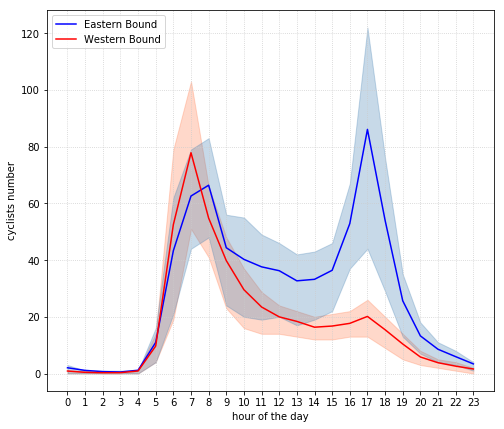

In [32]:
f, ax = plt.subplots(figsize=(8,7))

ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','mean')], color='b', label='Eastern Bound')
ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','mean')], color='r', label='Western Bound')

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','25%')], \
                summary_hour.loc[:,('Tamaki Drive WB','75%')], color='coral', alpha=0.3)

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','25%')], \
                summary_hour.loc[:,('Tamaki Drive EB','75%')], color='steelblue', alpha=0.3)

ax.legend(loc=2)

ax.set_xticks(range(24));
ax.grid(ls=':', color='0.8')

ax.set_xlabel('hour of the day')

ax.set_ylabel('cyclists number');

### looking at week days versus week-ends 

In [33]:
weekdays = df.loc[df.index.weekday_name.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]
weekends = df.loc[df.index.weekday_name.isin(['Sunday','Saturday'])]

In [34]:
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

Text(0.5,1,'week days')

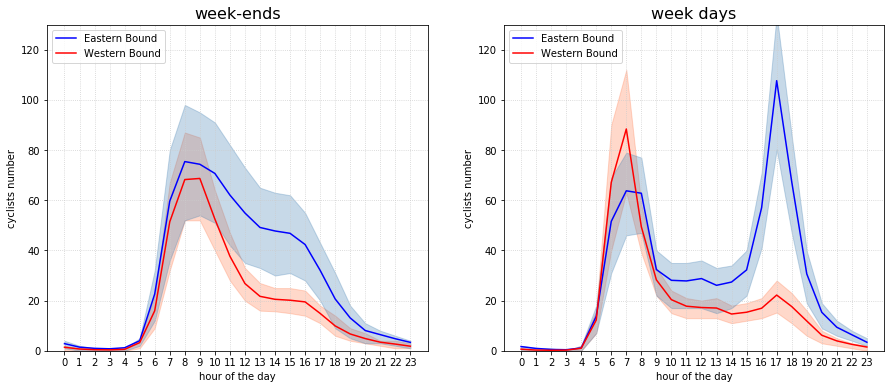

In [35]:
f, axes = plt.subplots(ncols = 2, figsize=(15,6))

axes = axes.flatten() 

ax = axes[0]

ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,('Tamaki Drive EB','mean')], color='b', label='Eastern Bound')
ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,('Tamaki Drive WB','mean')], color='r', label='Western Bound')

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,('Tamaki Drive WB','25%')], \
                summary_hour_weekends.loc[:,('Tamaki Drive WB','75%')], color='coral', alpha=0.3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,('Tamaki Drive EB','25%')], \
                summary_hour_weekends.loc[:,('Tamaki Drive EB','75%')], color='steelblue', alpha=0.3)

ax.legend(loc=2)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([0, 130])


ax.set_xlabel('hour of the day')

ax.set_ylabel('cyclists number');

ax.set_title('week-ends', fontsize=16)

ax =axes[1]

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,('Tamaki Drive EB','mean')], color='b', label='Eastern Bound')
ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,('Tamaki Drive WB','mean')], color='r', label='Western Bound')

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,('Tamaki Drive WB','25%')], \
                summary_hour_weekdays.loc[:,('Tamaki Drive WB','75%')], color='coral', alpha=0.3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,('Tamaki Drive EB','25%')], \
                summary_hour_weekdays.loc[:,('Tamaki Drive EB','75%')], color='steelblue', alpha=0.3)

ax.legend(loc=2)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([0, 130])

ax.set_xlabel('hour of the day')

ax.set_ylabel('cyclists number');

ax.set_title('week days', fontsize=16)

### getting rid of the outliers using a median filter 

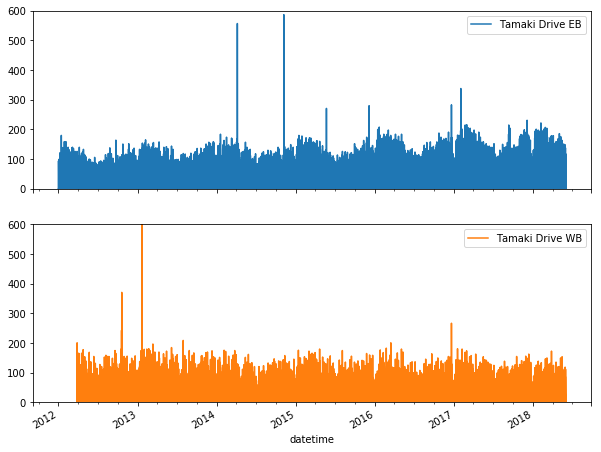

In [36]:
df.plot(subplots=True, figsize=(10, 8), **{'ylim':[0, 600]});

In [37]:
def median_filter(df, varname = 'Tamaki Drive EB', window=24, std=2): 
    
    dfc = df.copy() 
    
    dfc = dfc.loc[:,[varname]]
    
    dfc['median']= dfc[varname].rolling(window, center=True).median()
    
    dfc['std'] = dfc[varname].rolling(window, center=True).std()
    
    dfc.loc[dfc.loc[:,varname] >= dfc['median']+std*dfc['std'], varname] = np.nan
    
    dfc.loc[dfc.loc[:,varname] <= dfc['median']-std*dfc['std'], varname] = np.nan
    
    return dfc.loc[:, varname]

In [38]:
df_filtered = df.copy()

In [39]:
varname = 'Tamaki Drive EB'

In [40]:
df_filtered.loc[:,varname] = median_filter(df_filtered, varname = varname)

In [41]:
varname = 'Tamaki Drive WB'

In [42]:
df_filtered.loc[:,varname] = median_filter(df_filtered, varname = varname)

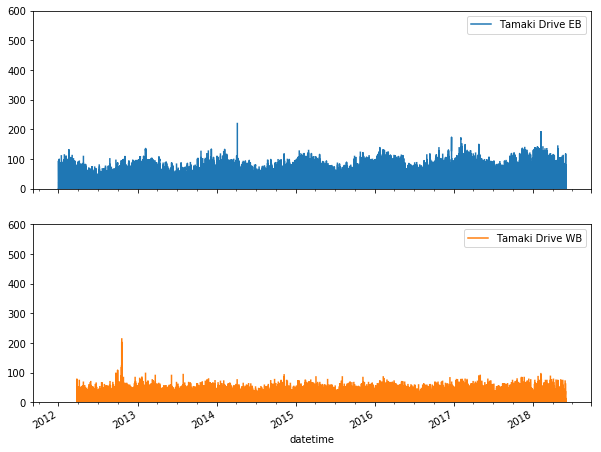

In [43]:
df_filtered.plot(subplots=True, figsize=(10, 8), **{'ylim':[0, 600]});

### resampling at the daily time-step, we only have the daily weather data ... 


In [44]:
df_filtered = df_filtered.resample('1D').sum()

In [45]:
df_filtered.head()

,Tamaki Drive EB,Tamaki Drive WB
datetime,,
2012-01-01,792.0,0.0
2012-01-02,430.0,0.0
2012-01-03,711.0,0.0
2012-01-04,852.0,0.0
2012-01-05,721.0,0.0


In [46]:
df_filtered.tail()

,Tamaki Drive EB,Tamaki Drive WB
datetime,,
2018-05-27,171.0,152.0
2018-05-28,563.0,255.0
2018-05-29,711.0,382.0
2018-05-30,649.0,269.0
2018-05-31,749.0,302.0


### we're gonna look at the cyclists count for Eastern Bound Tamaki Drive ... 

In [47]:
data = df_filtered.loc[:,['Tamaki Drive EB']]

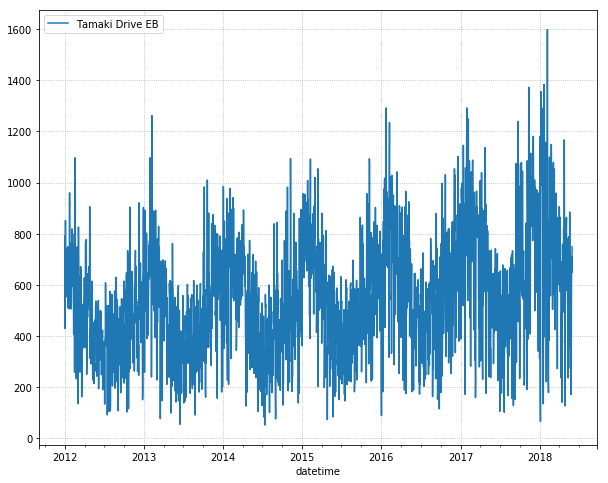

In [48]:
f, ax = plt.subplots(figsize=(10,8))
data.plot(ax=ax)
ax.grid(ls=':')
f.savefig('../figures/cycling_counts_Tamaki_drive_EB.png', dpi=200)

### this is the time-series we're gonna try and model and predict

### preparing the data 

In [49]:
data = data.rename({'Tamaki Drive EB':'y'}, axis=1)

In [50]:
data.tail()

,y
datetime,
2018-05-27,171.0
2018-05-28,563.0
2018-05-29,711.0
2018-05-30,649.0
2018-05-31,749.0


### defining here a few utility functions to do all the 'data wrangling'

In [51]:
def add_regressor(data, regressor, varname=None): 
    
    """
    adds a regressor to a dataframe of targets
    """
    
    data_with_regressors = data.copy()
    
    data_with_regressors.loc[:,varname] = regressor.loc[:,varname]
    
    return data_with_regressors

In [52]:
def prepare_data(data, year=2017): 
    
    """
    prepare the data for ingestion by fbprophet: 
    
    1) divide in training and test set, using the `year` parameter (int)
    
    2) reset the index and rename the `datetime` column to `ds`
    
    returns the training and test dataframes
    """
    
    
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

In [53]:
def make_verif(forecast, data_train, data_test): 
    """
    put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting
    
    """
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [54]:
def plot_verif(verif, year=2017):
    """
    plots the forecasts and observed data, the year parameters is used to highlight 
    the difference between the training and test data 
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [55]:
def plot_verif_component(verif, component='rain', year=2017): 
    """
    plots a specific component of the model
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
        
    ax.plot(train.index, train.loc[:,component], color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.loc[:, component+'_lower'], train.loc[:, component+'_upper'], color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
        
    ax.plot(test.index, test.loc[:,component], color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.loc[:, component+'_lower'], test.loc[:, component+'_upper'], color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [56]:
def add_regressor_to_future(future, regressors_list): 
    """
    adds extra regressors to a `future` dataframe created by fbprophet
    """
    
    futures = future.copy() 
    
    futures.index = pd.to_datetime(futures.ds)
    
    regressors = pd.concat(regressors_list, axis=1)
    
    futures = futures.merge(regressors, left_index=True, right_index=True)
    
    futures = futures.reset_index(drop = True) 
    
    return futures

### splits the data into a training and test set, and returns these data frames in a format **fbprophet** can understand 

In [57]:
data_train, data_test = prepare_data(data, 2017)

In [58]:
data_train.head()

,ds,y
0,2012-01-01,792.0
1,2012-01-02,430.0
2,2012-01-03,711.0
3,2012-01-04,852.0
4,2012-01-05,721.0


In [59]:
data_test.head()

,ds,y
0,2017-01-01,605.0
1,2017-01-02,388.0
2,2017-01-03,515.0
3,2017-01-04,474.0
4,2017-01-05,979.0


### instantiates, then fit the model to the training data 

The first step in **fbprophet** is to instantiate the model, it is there that you can set the `prior scales` for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.   

A general rule is that larger prior scales and larger number of Fourier series will make the model more flexible, but at the potential cost of generalisation: i.e. the model might [overfit](https://en.wikipedia.org/wiki/Overfitting), learning the noise (rather than the signal) in the training data, but 
    giving poor results when applied to yet unseen data (the test data)... setting these [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) can be more an art than a science ... 

In [60]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [61]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


### make the `future` dataframe 

In [62]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [63]:
future.head()

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05


In [64]:
future.tail()

,ds
2338,2018-05-27
2339,2018-05-28
2340,2018-05-29
2341,2018-05-30
2342,2018-05-31


### then forecasts 

In [65]:
forecast = m.predict(future)

### put it all together with the actual observations 

In [66]:
verif = make_verif(forecast, data_train, data_test)

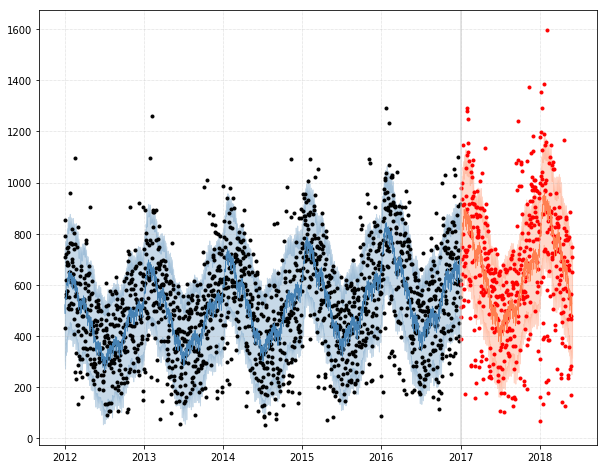

In [67]:
f = plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values 

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


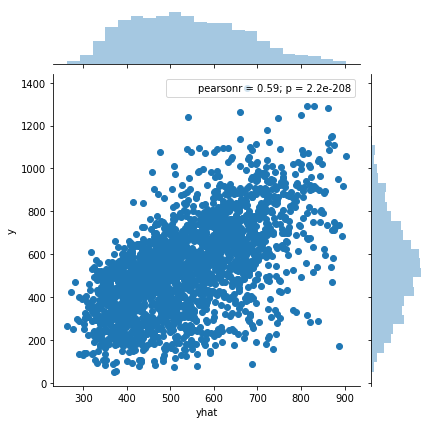

In [68]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:]);

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


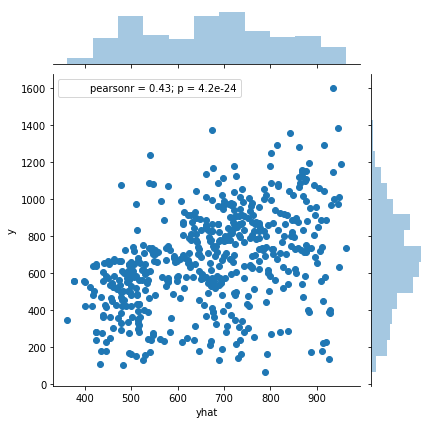

In [69]:
sns.jointplot(x='yhat', y='y', data = verif.loc['2017':,:])

### Mean Absolute Error (in number of cyclists)

In [70]:
MAE(verif.y.values, verif.yhat.values)

141.2392447471082

## now incorporating the effects of the holidays 

In [71]:
holidays_calendar = pd.read_csv('../data/holidays_calendars_2011_2018.csv')

In [72]:
holidays_calendar.loc[:,'ISO_date'] = pd.to_datetime(holidays_calendar.loc[:,'ISO_date'], dayfirst=True)

In [73]:
holidays_calendar = holidays_calendar.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [74]:
holidays_calendar = holidays_calendar.loc[-holidays_calendar.notes.str.contains('Not a public'),:]

In [75]:
holidays = holidays_calendar.loc[(holidays_calendar.loc[:,'Regional'] == 0) | holidays_calendar.RGR.str.contains('Auckland'),:]

In [76]:
holtype = 'full'

In [77]:
if holtype == 'category': 
    holidays = holidays.loc[:,['ISO_date','holiday_category']]
    holidays = holidays.rename({'holiday_category':'holiday'}, axis=1)
if holtype == 'code': 
    holidays = holidays.loc[:,['ISO_date','holiday_code']]
    holidays = holidays.rename({'holiday_code':'holiday'}, axis=1)
else: 
    holidays = holidays.loc[:,['ISO_date','holiday']]

In [78]:
holidays = holidays.rename({'ISO_date':'ds'}, axis=1)

In [79]:
holidays.tail()

,ds,holiday
164,2018-04-25,Anzac Day
166,2018-06-04,Queen's Birthday
170,2018-10-22,Labour Day
175,2018-12-25,Christmas Day
176,2018-12-26,Boxing Day


In [80]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [81]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/fbprophet-0.3.post2-py3.6.egg/fbprophet/forecaster.py:253: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [82]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [83]:
forecast = m.predict(future)

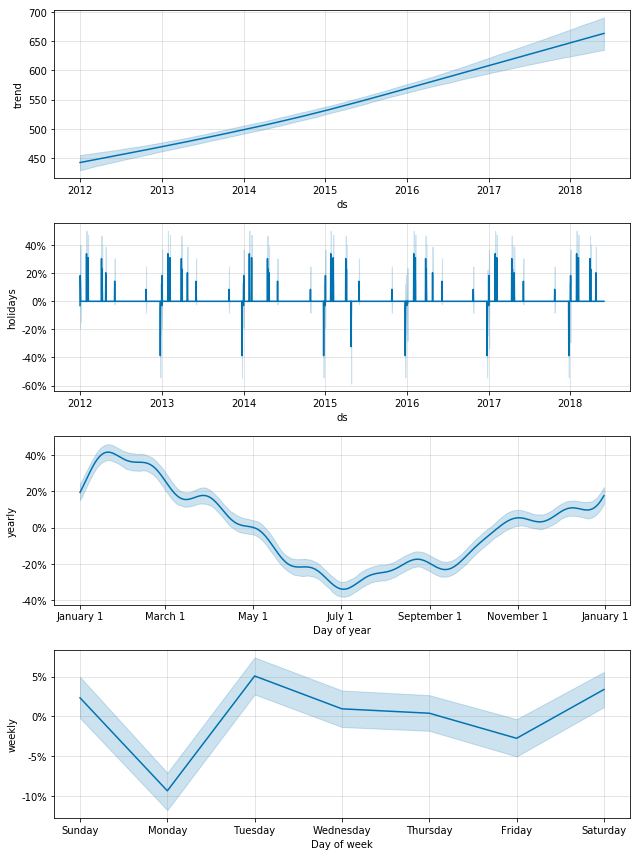

In [84]:
f = m.plot_components(forecast)

In [85]:
verif = make_verif(forecast, data_train, data_test)

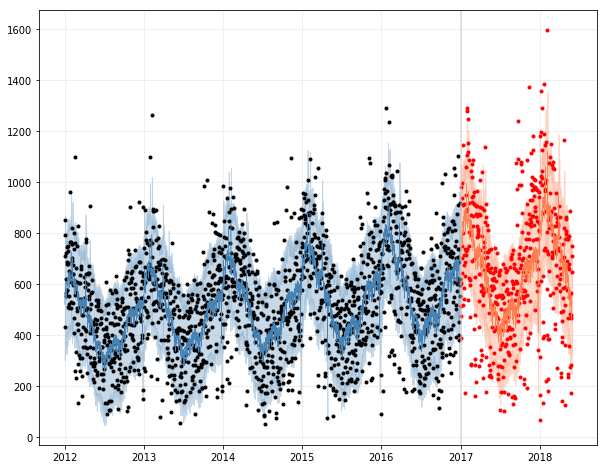

In [86]:
f = plot_verif(verif)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


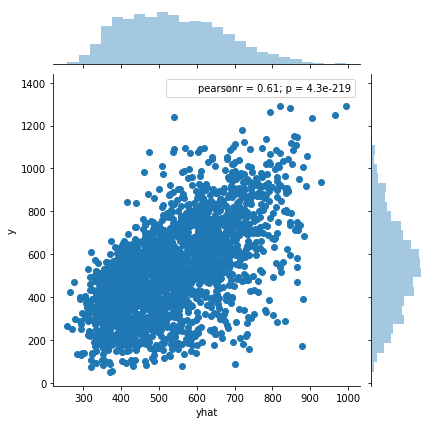

In [87]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:])

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


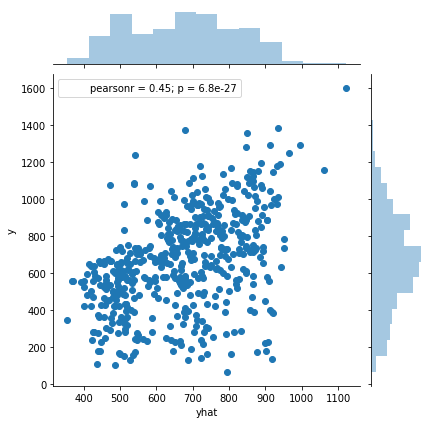

In [88]:
sns.jointplot(x='yhat', y='y', data = verif.loc['2017':,:])

In [89]:
MAE(verif.y.values, verif.yhat.values)

139.87885417487385

## incorporating the effects of weather conditions

#### we're gonna use sunshine hours, rainfall and wind

In [90]:
rain = pd.read_csv('../data/weather/Mangere_EWS_rain.csv', index_col=0, parse_dates=True)

In [91]:
sun = pd.read_csv('../data/weather/Mangere_EWS_sun.csv', index_col=0, parse_dates=True)

In [92]:
wind = pd.read_csv('../data/weather/Mangere_EWS_wind.csv', index_col=0, parse_dates=True)

In [93]:
rain = rain.loc['2012':,:]

In [94]:
sun = sun.loc['2012':,:]

In [95]:
wind = wind.loc['2012':,:]

### interpolate so that there are no missing values (not ideal, but will do for now)

In [96]:
rain = rain.interpolate(method='linear')

In [97]:
sun = sun.interpolate(method='linear')

In [98]:
wind = wind.interpolate(method='linear')

### adds the climate regressors to the data 

In [99]:
data_with_regressors = add_regressor(data, rain, varname='rain')

In [100]:
data_with_regressors = add_regressor(data_with_regressors, sun, varname='sun')

In [101]:
data_with_regressors = add_regressor(data_with_regressors, wind, varname='wind')

In [102]:
data_with_regressors.head()

,y,rain,sun,wind
datetime,,,,
2012-01-01,792.0,6.0,1.0,6.150000
2012-01-02,430.0,1.0,2.0,9.712500
2012-01-03,711.0,0.0,4.4,4.154167
2012-01-04,852.0,0.2,1.7,3.554167
2012-01-05,721.0,2.8,5.8,2.737500


### prepare the data and subsets (train and test set)

In [103]:
data_train, data_test = prepare_data(data_with_regressors, 2017)

### instantiates the model using the same paramaters as before 

In [104]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

### adds the extra weather regressors to the model

In [105]:
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')
m.add_regressor('wind', prior_scale=0.5, mode='multiplicative')

In [106]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [107]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [108]:
futures = add_regressor_to_future(future, [rain, sun, wind])

In [109]:
futures.head()

,ds,rain,sun,wind
0,2012-01-01,6.0,1.0,6.150000
1,2012-01-02,1.0,2.0,9.712500
2,2012-01-03,0.0,4.4,4.154167
3,2012-01-04,0.2,1.7,3.554167
4,2012-01-05,2.8,5.8,2.737500


In [110]:
forecast = m.predict(futures)

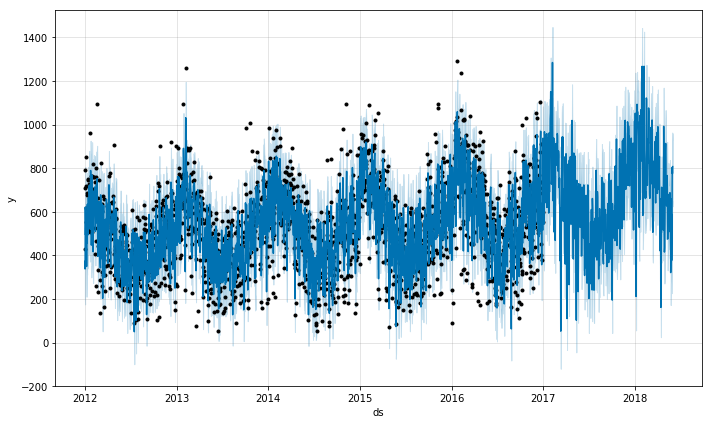

In [111]:
f = m.plot(forecast)

### put it all together for plotting and evaluation 

In [112]:
verif = make_verif(forecast, data_train, data_test)

In [113]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anzac Day,Anzac Day_lower,Anzac Day_upper,Anzac Day Holiday,...,wind_lower,wind_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2012-01-01,2012-01-01,453.814235,211.554581,528.095626,443.968558,463.556071,0.0,0.0,0.0,0.0,...,-0.091303,-0.081402,0.162900,0.133642,0.193506,0.0,0.0,0.0,372.360538,792.0
2012-01-02,2012-01-02,453.849960,175.489026,499.500002,444.021374,463.585757,0.0,0.0,0.0,0.0,...,-0.280966,-0.250495,0.173460,0.144601,0.202982,0.0,0.0,0.0,338.095187,430.0
2012-01-03,2012-01-03,453.885685,433.739096,806.117107,444.074191,463.602674,0.0,0.0,0.0,0.0,...,0.013331,0.014952,0.184274,0.154539,0.213423,0.0,0.0,0.0,622.277878,711.0
2012-01-04,2012-01-04,453.921409,332.233494,633.877309,444.127007,463.604131,0.0,0.0,0.0,0.0,...,0.041809,0.046895,0.195225,0.164851,0.224420,0.0,0.0,0.0,493.995678,852.0
2012-01-05,2012-01-05,453.957134,454.157345,741.933544,444.179824,463.605588,0.0,0.0,0.0,0.0,...,0.080572,0.090374,0.206195,0.176427,0.234723,0.0,0.0,0.0,595.256203,721.0


### clips the negative values 

In [114]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [115]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

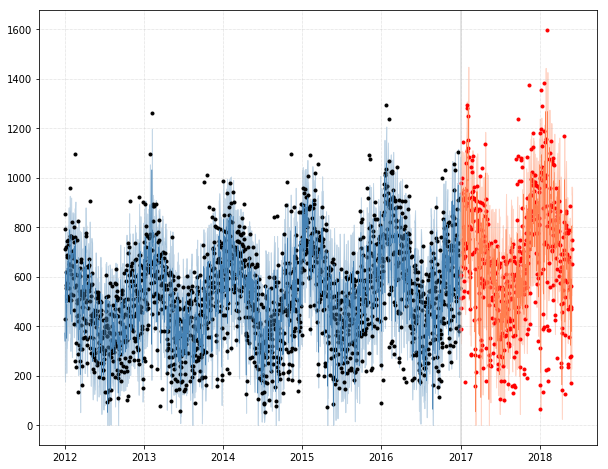

In [116]:
f =  plot_verif(verif)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


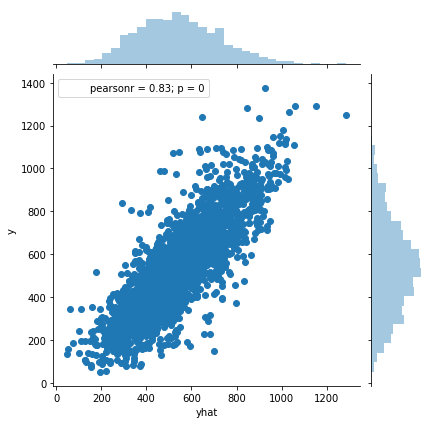

In [117]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:])

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


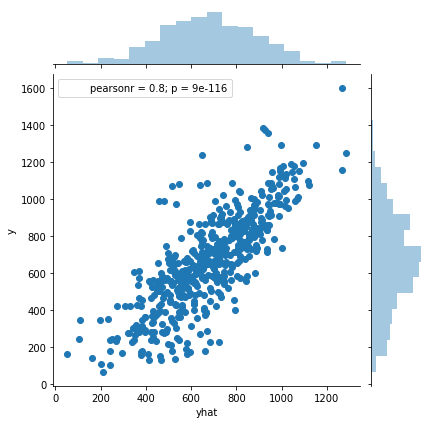

In [118]:
f = sns.jointplot(x='yhat', y='y', data = verif.loc['2017':])
plt.savefig('../figures/joint_plot_climate_2017.png', dpi=200)

### Mean Absolute Error 

In [119]:
MAE(verif.y.values, verif.yhat.values)

92.46787790542231

### plot the contribution of the different climate variables to the response variable (in percentage of the trend component, as we chose a multiplicative model)

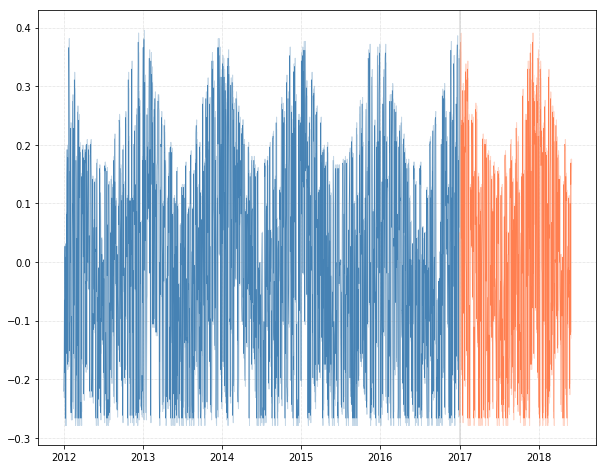

In [120]:
f  = plot_verif_component(verif, component = 'sun')

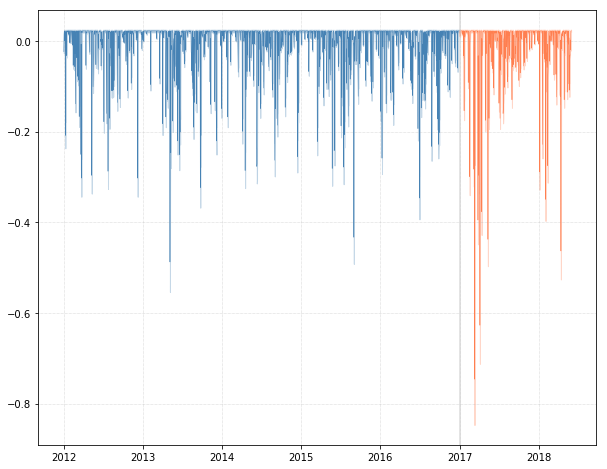

In [121]:
f  = plot_verif_component(verif, component = 'rain')

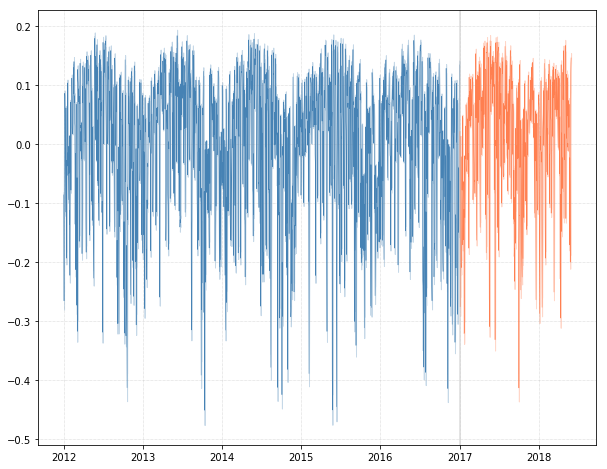

In [122]:
f  = plot_verif_component(verif, component = 'wind')

### plots the combined contribution of the climate extra-regressors

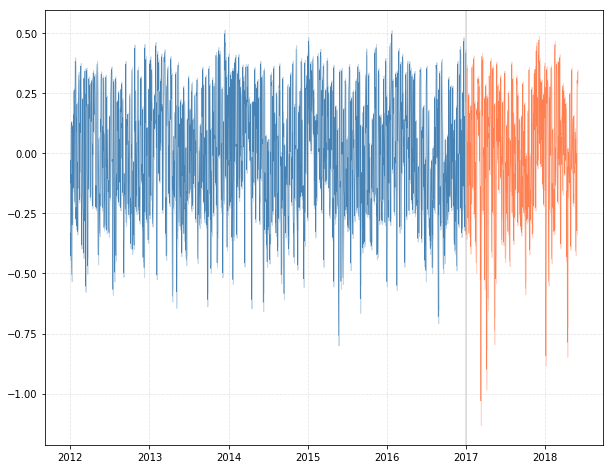

In [123]:
f = plot_verif_component(verif, component = 'extra_regressors_multiplicative')

### zoom in on the post 2016 period (test set)

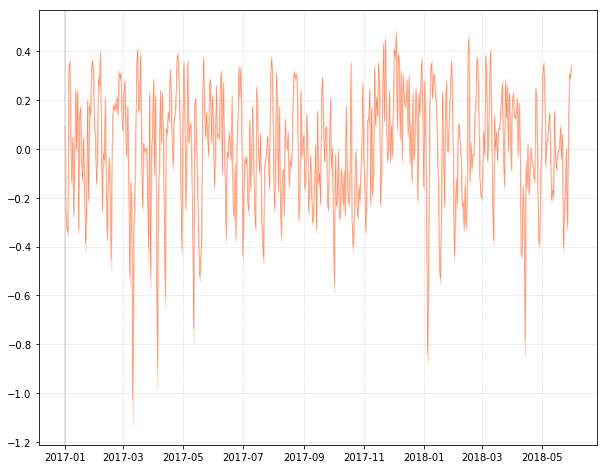

In [124]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'extra_regressors_multiplicative')

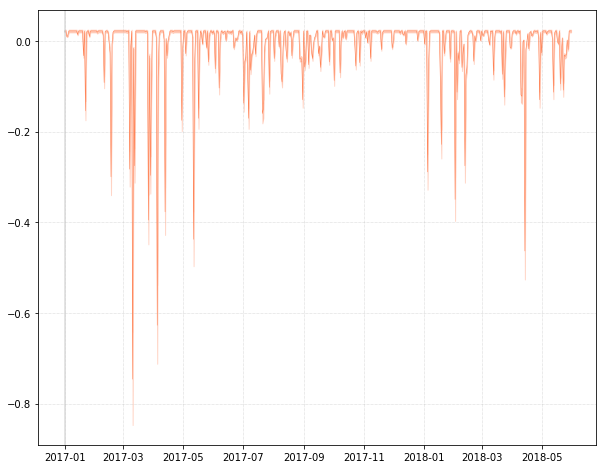

In [125]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'rain')

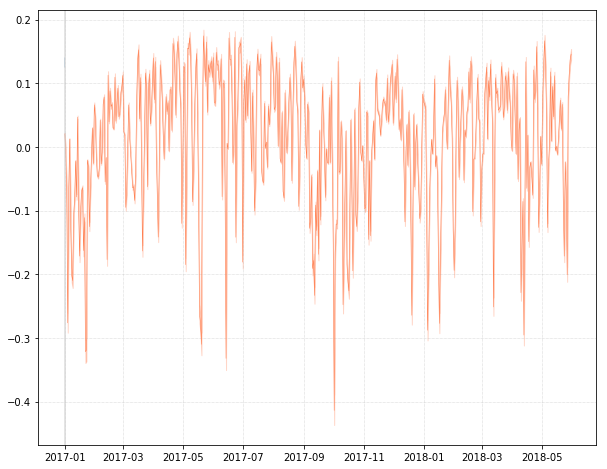

In [126]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'wind')

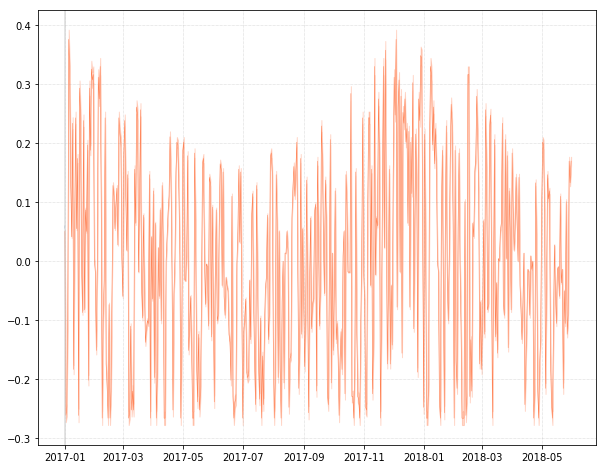

In [127]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'sun')

### plots the forecasts (`yhat`, orange line) and the observed values (`y`, blue line) for the first 8 months of 2017

In [128]:
verif.loc['2017-01-01':'2017-08-31',['y','yhat']].corr()

,y,yhat
y,1.000000,0.855902
yhat,0.855902,1.000000


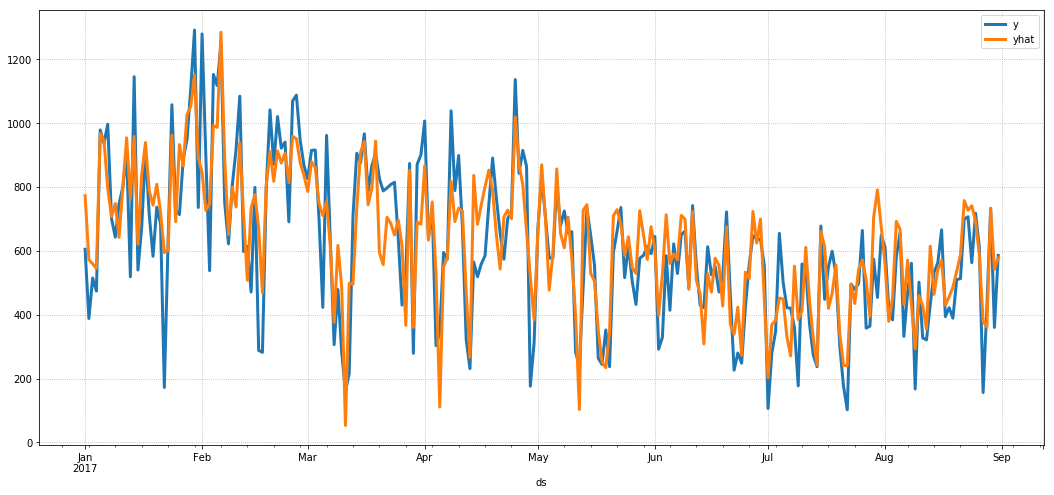

In [129]:
f, ax = plt.subplots(figsize=(18,8))
verif.loc['2017-01-01':'2017-08-31',['y','yhat']].plot(lw=3, ax=ax)
ax.grid(ls=':')
f.savefig('../figures/forecasts_obs_2017-08.png', dpi=200)

### running correlations (over 90 days) between observed and modelled / predicted values, useful to identify when the model didnt perform well, which could be pointing towards factors that we did not consider 

In [130]:
corr = verif.loc[:,['y','yhat']].rolling(window=90).corr().iloc[0::2,1]

In [131]:
corr.index = corr.index.droplevel(1)

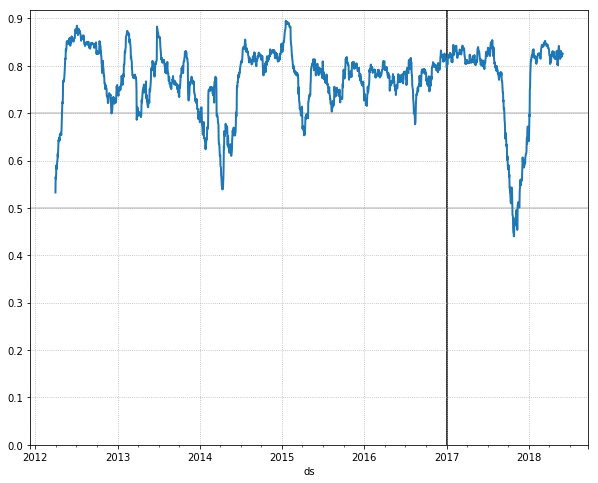

In [132]:
f, ax = plt.subplots(figsize=(10, 8))
corr.plot(ax=ax, lw=2)
ax.axhline(0.7, color='0.8', zorder=-1)
ax.axhline(0.5, color='0.8', zorder=-1)
ax.axvline('2017', color='k', zorder=-1)
ax.grid(ls=':')
ax.set_yticks(np.arange(0, 1., 0.1)); 